In [172]:
import pandas as pd
import seaborn as sbs
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import ElasticNet
from sklearn.metrics import classification_report, plot_confusion_matrix, explained_variance_score, r2_score, mean_absolute_error

from keras.models import Model, Sequential
from keras.layers import LSTM, Dense

In [173]:
def generate_np_data(data, col_x, col_y, look_back, predict_forward, N, categorize = False, zero_missing=True):
    X = []
    Y = []
    
    unique_location = data.wsnm.unique()
    
    dataframe_X = data[['wsnm'] + col_x]
    dataframe_Y = data[['wsnm'] + col_y]
    
    n_samples = 0
    last = -1
    
    for loc in unique_location:
        data_x = np.array(dataframe_X[dataframe_X.wsnm == loc].drop(columns=['wsnm']))
        data_y = np.array(dataframe_Y[dataframe_Y.wsnm == loc].drop(columns=['wsnm']))
        
        for i in range(len(data_x) - look_back - predict_forward):
            x_ = data_x[i:i+look_back]
            y_ = data_y[i+look_back - 1 + predict_forward]

            if not np.isnan(x_).any() and (not np.isnan(y_).any() or zero_missing):
                X.append(x_)
                n_samples += 1

                if zero_missing:
                    if np.isnan(y_).any():
                        Y.append(0)
                    elif categorize:
                        Y.append(1 if y_ > 0 else 0)
                    else:
                        Y.append(y_)
                else:
                    if categorize:
                        Y.append(1 if y_ > 0 else 0)
                    else:
                        Y.append(y_)
                        
            if n_samples % 5000 == 0 and n_samples != last:
                print(n_samples)
                last = n_samples
            if n_samples > N:
                 return np.array(X), np.array(Y)
 
    return np.array(X), np.array(Y)

In [174]:
def generate_np_data2(data, unique_name, unique_colname, col_x, col_y, look_back, predict_forward, N, categorize = False, zero_missing=True):
    X = []
    Y = []
    
    unique_location = data[unique_name].unique()
    
    dataframe_X = data[[unique_colname] + col_x ] #['wsnm'] + col_x]
    dataframe_Y = data[[unique_colname] + col_y ] #['wsnm'] + col_y]
    
    n_samples = 0
    last = -1
    
    for loc in unique_location:
        data_x = np.array(dataframe_X[dataframe_X[unique_colname] == loc].drop(columns=[unique_colname]))
        data_y = np.array(dataframe_Y[dataframe_Y[unique_colname] == loc].drop(columns=[unique_colname]))
        
        for i in range(len(data_x) - look_back - predict_forward):
            x_ = data_x[i:i+look_back]
            y_ = data_y[i+look_back - 1 + predict_forward]

            if not np.isnan(x_).any() and (not np.isnan(y_).any() or zero_missing):
                X.append(x_)
                n_samples += 1

                if zero_missing:
                    if np.isnan(y_).any():
                        Y.append(0)
                    elif categorize:
                        Y.append(1 if y_ > 0 else 0)
                    else:
                        Y.append(y_)
                else:
                    if categorize:
                        Y.append(1 if y_ > 0 else 0)
                    else:
                        Y.append(y_)
                        
            if n_samples % 5000 == 0 and n_samples != last:
                print(n_samples)
                last = n_samples
            if n_samples > N:
                 return np.array(X), np.array(Y)
 
    return np.array(X), np.array(Y)

In [175]:
def get_model_lstm(n_steps, n_features):
    model = Sequential()
    
    model.add(LSTM(128, input_shape=(n_steps, n_features)))

    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics =['acc'])
    
    return model

In [176]:
def get_model_lstm_regression(n_steps, n_features, n_output):
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(n_steps, n_features)))

    model.add(Dense(n_output, activation = 'relu'))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics =['mse', 'mae'])
    
    return model

In [177]:
def fahrenheit_to_celsius(temp):
    return (temp - 32) * 5 / 9

---

# Loading Data|

In [178]:
# https://www.kaggle.com/PROPPG-PPG/hourly-weather-surface-brazil-southeast-region
#data = pd.read_csv("sudeste.csv")
data = pd.read_csv("SBBR2.csv", usecols=['station', 'valid', 'tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'p01i', 'alti', 'vsby', 'gust'])


In [179]:
data.describe()

,tmpf,dwpf,relh,drct,sknt,p01i,alti,vsby,gust
count,9172.000000,9172.000000,9171.000000,8069.000000,9168.000000,9179.0,9173.000000,9177.000000,65.000000
mean,72.905844,60.686175,69.286312,145.828479,5.362456,0.0,30.086770,6.013219,24.876923
std,7.770043,7.699213,20.347028,102.008089,3.500729,0.0,0.292426,0.818319,6.175829
min,42.800000,30.200000,10.450000,0.000000,0.000000,0.0,3.600000,0.030000,14.000000
25%,68.000000,53.600000,54.300000,70.000000,3.000000,0.0,30.030000,6.210000,21.000000
50%,71.600000,64.400000,73.440000,100.000000,5.000000,0.0,30.090000,6.210000,24.000000
75%,78.800000,66.200000,88.180000,250.000000,8.000000,0.0,30.150000,6.210000,28.000000
max,98.600000,71.600000,100.000000,360.000000,27.000000,0.0,34.230000,6.210000,55.000000


In [180]:
data.head()

,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,vsby,gust
0,SBBR,2019-11-25 00:00,71.6,68.0,88.43,180.0,5.0,0.0,30.06,6.21,NaN
1,SBBR,2019-11-25 01:00,69.8,68.0,94.01,170.0,5.0,0.0,30.09,6.21,NaN
2,SBBR,2019-11-25 02:00,69.8,66.2,88.34,150.0,9.0,0.0,30.09,6.21,NaN
3,SBBR,2019-11-25 03:00,69.8,66.2,88.34,120.0,4.0,0.0,30.06,6.21,NaN
4,SBBR,2019-11-25 04:00,68.0,66.2,93.97,110.0,4.0,0.0,30.03,6.21,NaN


In [181]:
#data.wsnm.unique()
data.station.unique()

array(['SBBR'], dtype=object)

### Data from INMET

- __wsid__: Weather station id
- __wsnm__: Name station (usually city location or nickname)
- __evlt__: Elevation
- __elvt__: Elevation
- __lat__: Latitude
- __lon__: Longitude
- __inme__: Station number (INMET number) for the location
- __city__: City
- __prov__: State (Province)
- __date__: Date of observation
- __yr__: The year (2000-2016)
- __mo__: The month (0-12)
- __da__: The day (0-31)
- __hr__: The hour (0-23)
- __prcp__: Amount of precipitation in millimetres (last hour)
- __stp__: Air pressure for the hour in hPa to tenths (instant)
- __smax__: Maximum air pressure for the last hour in hPa to tenths
- __smin__: Minimum air pressure for the last hour in hPa to tenths
- __gbrd__: Solar radiation KJ/m2
- __temp__: Air temperature (instant) in celsius degrees
- __dewp__: Dew point temperature (instant) in celsius degrees
- __dmax__: Maximum dew point temperature for the last hour in celsius degrees
- __dmin__: Minimum dew point temperature for the last hour in celsius degrees
- __hmax__: Maximum relative humid temperature for the last hour in %
- __hmin__: Minimum relative humid temperature for the last hour in %
- __wdsp__: Wind speed in metres per second
- __wdct__: Wind direction in radius degrees (0-360)
- __gust__: Wind gust in metres per second
---

### Data from METAR

- __station__: three or four character site identifier
- __valid__: timestamp of the observation
- __tmpf__: Air Temperature in Fahrenheit, typically @ 2 meters
- __dwpf__: Dew Point Temperature in Fahrenheit, typically @ 2 meters
- __relh__: Relative Humidity in %
- __drct__: Wind Direction in degrees from north
- __sknt__: Wind Speed in knots 
- __p01i__: One hour precipitation for the period from the observation time to the time of the previous hourly precipitation reset. This varies slightly by site. Values are in inches. This value may or may not contain frozen precipitation melted by some device on the sensor or estimated by some other means. Unfortunately, we do not know of an authoritative database denoting which station has which sensor.
- __alti__: Pressure altimeter in inches
- __mslp__: Sea Level Pressure in millibar
- __vsby__: Visibility in miles
- __gust__: Wind Gust in knots
- __skyc1__: Sky Level 1 Coverage
- __skyc2__: Sky Level 2 Coverage
- __skyc3__: Sky Level 3 Coverage
- __skyc4__: Sky Level 4 Coverage
- __skyl1__: Sky Level 1 Altitude in feet
- __skyl2__: Sky Level 2 Altitude in feet
- __skyl3__: Sky Level 3 Altitude in feet
- __skyl4__: Sky Level 4 Altitude in feet
- __wxcodes__: Present Weather Codes (space seperated)
- __feel__: Apparent Temperature (Wind Chill or Heat Index) in Fahrenheit
- __ice_accretion_1hr__: Ice Accretion over 1 Hour (inches)
- __ice_accretion_3hr__: Ice Accretion over 3 Hours (inches)
- __ice_accretion_6hr__: Ice Accretion over 6 Hours (inches)
- __peak_wind_gust__: Peak Wind Gust (from PK WND METAR remark) (knots)
- __peak_wind_drct__: Peak Wind Gust Direction (from PK WND METAR remark) (deg)
- __peak_wind_time__: Peak Wind Gust Time (from PK WND METAR remark)
- __metar__: unprocessed reported observation in METAR format 
---

## Correlation Map

<AxesSubplot:>

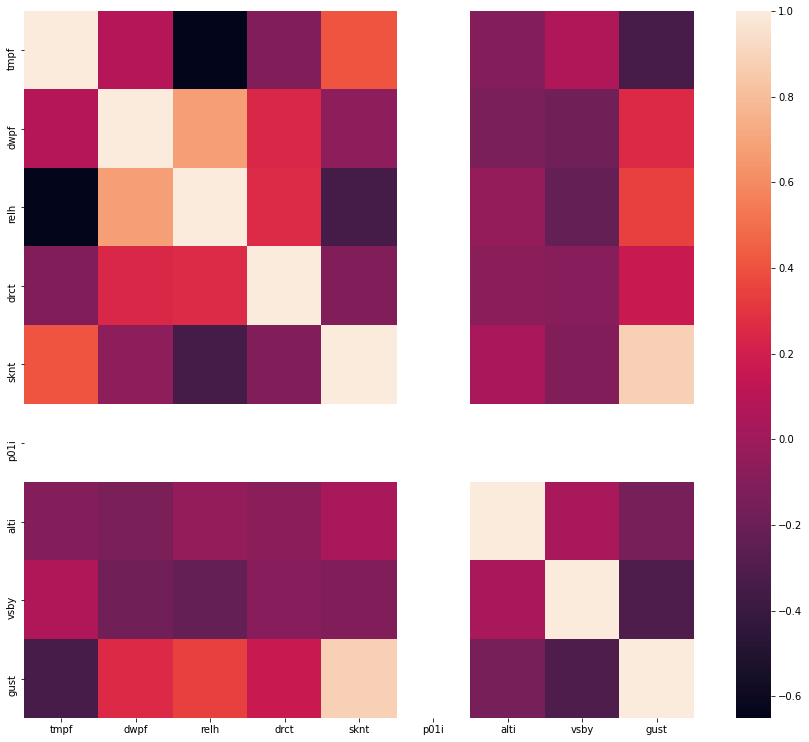

In [182]:
plt.rcParams["figure.figsize"] = [15,13]
sbs.heatmap(data.corr())

## Histogram

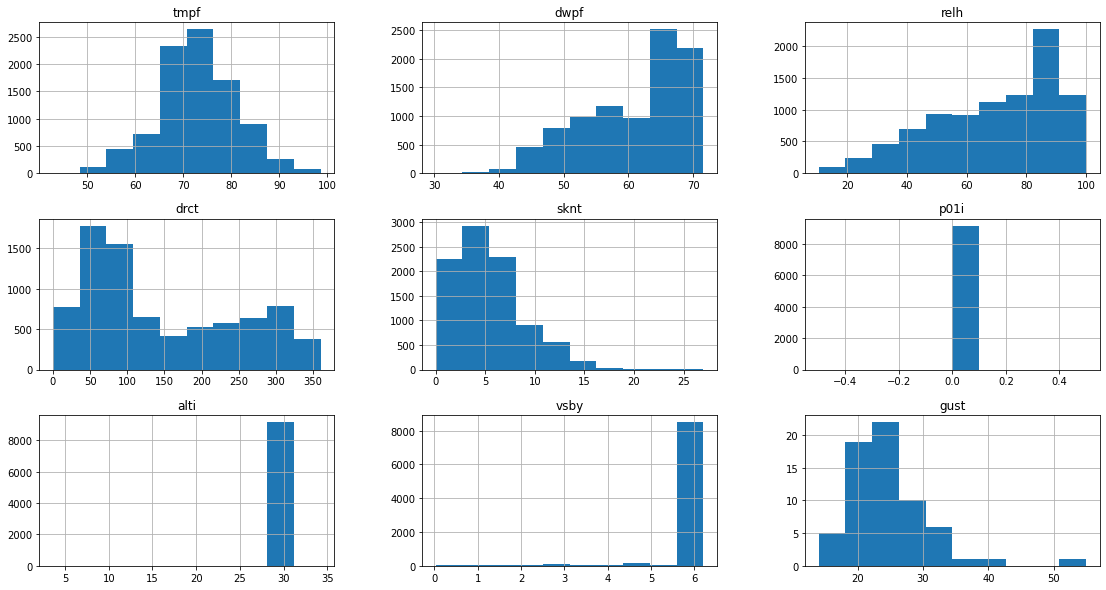

In [183]:
plt.rcParams["figure.figsize"] = [19,10]
data.hist()
plt.show()

---

# Predicting visibility range of next 3 hours

## From tmpf, dwpf, relh, drct, sknt, p01i, alti of last 12 hours

In [333]:
x_col = ['tmpf','dwpf','relh','drct','sknt','p01i','alti']
y_col = ['vsby']


In [334]:
look_back = 12
predict_forward = 3
N = 100000

#X, Y = generate_np_data(data, x_col, y_col, look_back, predict_forward, N, True, False)
X, Y = generate_np_data2(data, 'station', 'station', x_col, y_col, look_back, predict_forward, N, True, False)

train_size = 0.9

X_train, X_test = X[0:int(train_size * len(X))], X[int(train_size * len(X)):]
y_train, y_test = Y[0:int(train_size * len(Y))], Y[int(train_size * len(Y)):]

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)

0
X_train shape (3185, 12, 7)
y_train shape (3185,)


## Using Random Forest, N Trees = 150

In [335]:
rf = RandomForestRegressor(n_estimators=150, n_jobs=8)

In [336]:
s_x = X_train.shape

rf.fit(X_train.reshape(s_x[0], s_x[1] * s_x[2]), y_train)

RandomForestRegressor(n_estimators=150, n_jobs=8)

### Results

In [337]:
s_x = X_test.shape
y_pred = rf.predict(X_test.reshape(s_x[0], s_x[1] * s_x[2]))

In [338]:
r2_tree = r2_score(y_test, y_pred, multioutput='raw_values')
mae_tree = mean_absolute_error(y_test, y_pred, multioutput='raw_values')

In [339]:
print("R^2 Score for each value (1 is the best, 0 is the worse):",r2_tree)
print("Mean Absolute Error for each value (less is better):", mae_tree)

R^2 Score for each value (1 is the best, 0 is the worse): [1.]
Mean Absolute Error for each value (less is better): [0.]


---

## Using Elastic Net

In [340]:
en = ElasticNet(max_iter=50000)

In [341]:
s_x = X_train.shape

en.fit(X_train.reshape(s_x[0], s_x[1] * s_x[2]), y_train)

d:\program files\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


ElasticNet(max_iter=50000)

### Results

In [342]:
s_x = X_test.shape
y_pred = en.predict(X_test.reshape(s_x[0], s_x[1] * s_x[2]))

In [343]:
r2_en = r2_score(y_test, y_pred, multioutput='raw_values')
mae_en = mean_absolute_error(y_test, y_pred, multioutput='raw_values')

In [344]:
print("R^2 Score for each value (1 is the best, 0 is the worse):",r2_en)
print("Mean Absolute Error for each value (less is better):", mae_en)

R^2 Score for each value (1 is the best, 0 is the worse): [1.]
Mean Absolute Error for each value (less is better): [0.]


---

## Using LSTM

In [345]:
model = get_model_lstm_regression(look_back, X_train.shape[2], len(y_train.shape))

In [346]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size=64, epochs=10)

Epoch 1/10
50/50 [==============================] - 2s 45ms/step - loss: 0.0768 - mse: 0.0768 - mae: 0.1827 - val_loss: 0.0326 - val_mse: 0.0326 - val_mae: 0.1605
Epoch 2/10
50/50 [==============================] - 1s 23ms/step - loss: 0.0137 - mse: 0.0137 - mae: 0.0930 - val_loss: 0.0286 - val_mse: 0.0286 - val_mae: 0.1474
Epoch 3/10
50/50 [==============================] - 1s 27ms/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0652 - val_loss: 0.0026 - val_mse: 0.0026 - val_mae: 0.0376
Epoch 4/10
50/50 [==============================] - 1s 24ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0545 - val_loss: 0.0039 - val_mse: 0.0039 - val_mae: 0.0556
Epoch 5/10
50/50 [==============================] - 1s 24ms/step - loss: 0.0043 - mse: 0.0043 - mae: 0.0517 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0468
Epoch 6/10
50/50 [==============================] - 1s 23ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0446 - val_loss: 6.5438e-04 - val_mse: 6.5438e-04 - val_mae: 0.0167
Epoch 7/10
50/

### Results

In [347]:
s_x = X_test.shape
y_pred = model.predict(X_test)

In [348]:
r2_lstm = r2_score(y_test, y_pred, multioutput='raw_values')
mae_lstm = mean_absolute_error(y_test, y_pred, multioutput='raw_values')

In [349]:
print("R^2 Score for each value (1 is the best, 0 is the worse):",r2_lstm)
print("Mean Absolute Error for each value (less is better):", mae_lstm)

R^2 Score for each value (1 is the best, 0 is the worse): [0.]
Mean Absolute Error for each value (less is better): [0.01218089]


---

In [350]:
print("Mean R^2 Score Random Forest:", np.round(np.mean(r2_tree), 3))
print("Mean R^2 Score Elastic Net:", np.round(np.mean(r2_en), 3))
print("Mean R^2 Score LSTM:", np.round(np.mean(r2_lstm), 3))

Mean R^2 Score Random Forest: 1.0
Mean R^2 Score Elastic Net: 1.0
Mean R^2 Score LSTM: 0.0


In [351]:
print("Mean MAE Random Forest:", np.round(np.mean(mae_tree), 3))
print("Mean MAE Elastic Net:", np.round(np.mean(mae_en), 3))
print("Mean MAE LSTM:", np.round(np.mean(mae_lstm), 3))

Mean MAE Random Forest: 0.0
Mean MAE Elastic Net: 0.0
Mean MAE LSTM: 0.012
